In [1]:
!sudo apt install tesseract-ocr


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,555 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [2]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.4-py2.py3-none-any.whl size=13431 sha256=5cbd06bc3b30077d3cf25568aafbf24e17d110b21093962aed401730a4da468b
  Stored in directory: /root/.cache/pip/wheels/63/2a/a0/7596d2e0a73cf0aeffd6f6170862c4e73f3763b7827e48691a
Successfully built pytesseract


In [3]:
!pip install tensorflow==2.2

In [4]:
!pip install textdistance

In [0]:
# This script detect the plate number 
# We devised the plate number into 2 patch right-left 
# we use tesseract as an ocr engine to detect the number in each patch 
# also to detect the number of plate as a one single block
# The outputs of this script are : full_plate,plate_num_left,plate_num_right
# From this outputs we will  predict the right plate number .....



# Import packages
import os
import cv2
import numpy as np
import sys
#from skimage import io
from tensorflow.lite.python.interpreter import Interpreter
import pytesseract
import textdistance as td
import re
from google.colab.patches import cv2_imshow

In [0]:
# Get path to current working directory
CWD_PATH = os.getcwd()

In [0]:
# With testing you will know which is the best
min_conf_threshold = 0.6
images = '/content/drive/My Drive/Ai_Team/5.jpg'

In [0]:
# path to model
PATH_TO_CKPT = os.path.join(CWD_PATH, '/content/drive/My Drive/Ai_Team/model.tflite')
labels = '/content/drive/My Drive/Ai_Team/labelmap.txt'

In [0]:
#pkg = importlib.util.find_spec('tflite_runtime')
# Have to do a weird fix for label map if using the COCO "starter model" from
# https://www.tensorflow.org/lite/models/object_detection/overview
# First label is '???', which has to be removed.

if labels[0] == '???':
    del(labels[0])


In [0]:
# Load the Tensorflow Lite model.
interpreter = Interpreter(model_path=PATH_TO_CKPT)
interpreter.allocate_tensors()

In [0]:
# Get model details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

floating_model = (input_details[0]['dtype'] == np.float32)

input_mean = 127.5
input_std = 127.5
total_time = 0

In [0]:
# Load image and resize to expected shape [1xHxWx3]
# Two option to read the img
image = cv2.imread(images)
#image = io.imread(images)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
imH, imW, _ = image.shape
image_resized = cv2.resize(image_rgb, (width, height))
input_data = np.expand_dims(image_resized, axis=0)
# Normalize pixel values if using a floating model (i.e. if model is non-quantized)
if floating_model:
    input_data = (np.float32(input_data) - input_mean) / input_std
# Perform the actual detection by running the model with the image as input
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

In [0]:
# Retrieve detection results
# Bounding box coordinates of detected objects
boxes = interpreter.get_tensor(output_details[0]['index'])[0]
classes = interpreter.get_tensor(output_details[1]['index'])[
    0]  # Class index of detected objects
scores = interpreter.get_tensor(output_details[2]['index'])[
    0]  # Confidence of detected objects
# num = interpreter.get_tensor(output_details[3]['index'])[0]  # Total number of detected objects (inaccurate and not needed)
# Loop over all detections and draw detection box if confidence is above minimum threshold
for i in range(len(scores)):
    if ((scores[i] > min_conf_threshold) and (scores[i] <= 1.0)):
        # Get bounding box coordinates and draw box
        # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
        ymin = int(max(1, (boxes[i][0] * imH)))
        xmin = int(max(1, (boxes[i][1] * imW)))
        ymax = int(min(imH, (boxes[i][2] * imH)))
        xmax = int(min(imW, (boxes[i][3] * imW)))
        #cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (10, 255, 0), 2)
# only the plate number will be appeared
croped_img = image[ymin:ymax, xmin:xmax]

In [16]:
cv2_imshow(image)

Output hidden; open in https://colab.research.google.com to view.

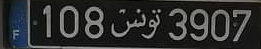

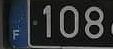

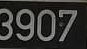

-1

In [24]:
#  xmin -------------> xmax =297--------- ymin = 362 -
#                                                    -
#                                                    -
#                                                    -
#                                          ymax=387  -

# this will return the size of the plate : ***TN****
dim_img = croped_img.shape[1]

# will crop the plate into 2 patch right and left for ocr precision purposes
left = croped_img[:, :int(dim_img/2.3)]
right = croped_img[:, int(dim_img/1.5):]

#To visualize the patches 

cv2_imshow(croped_img)
cv2_imshow(left)
cv2_imshow(right)
cv2.waitKey(0)

In [0]:
# Tesseract engine 
ocr = pytesseract.image_to_string(croped_img)
ocr_left = pytesseract.image_to_string(left)
ocr_right = pytesseract.image_to_string(right)


In [0]:
plate_num_right = ""
plate_num_left = ""
full_plate = ""

# Collectin only the numbers in each patch 

for i in ocr_left:
    if bool(re.match(r"[0-9]+", i)):
        plate_num_left += i


for j in ocr_right:
    if bool(re.match(r"[0-9]+", j)):
        plate_num_right += j

for k in ocr:
    if bool(re.match(r"[0-9]+", k)):
        full_plate += k

In [31]:
# Print results 

print('full_plate : ',full_plate)
print('plate_num_left : ', plate_num_left)
print('plate_num_right : ', plate_num_right)


cv2.destroyAllWindows()

# for the image named 52.jpeg  (the original plate number of this car is : 153 TN 4106 )the result will be : 

#   1530254106
#   153 

full_plate :  10853907
plate_num_left :  108
plate_num_right :  3907
